In [ ]:
# Allow imports from parent directory 
import os, sys
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    sys.path.append(os.path.abspath(".")) 
    
from astropy.io import fits
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from Analysis import plot_sky_density_FS
from Analysis import plot_sky_density_healpy

# Density Maps (1/2) - Including all b
- The plotting pipelines are available in `Analysis` by defining them as functions it was easy to optimise hyperparamers
- This was later removed as the bugle sources were too noisy and saturating the images

In [24]:
# File path
rgb_data_path = 'data/Allsky_Gaia_42481846_extinction_corrected_filtered_allb.fits'

# Load the FITS file with data used in this analysis
with fits.open(rgb_data_path, memmap=True) as hdul:
    data = hdul[1].data 
    ra = data['ra']
    dec = data['dec']
    l = data['l']
    b = data['b']
    dered_G = data['dered_G']
    dered_BP_RP = data['dered_BP_RP']

# magnitude cut
mag_bins = [14., 18.5]

# -------------------------------
# Global filter: color + magnitude
# -------------------------------
w = (dered_BP_RP > 1.0) & (dered_G > mag_bins[0]) & (dered_G < mag_bins[1])

# Apply to all relevant arrays
ra = ra[w]
dec = dec[w]
l = l[w]
b = b[w]
dered_G = dered_G[w]

# -------------------------------
# All-sky dataframe (Galactic)
# -------------------------------
all_sky = pd.DataFrame({
    'l': l,
    'b': b,
    'dered_G': dered_G
})

# -------------------------------
# Field-of-stream (FoS) filter in RA/Dec
# -------------------------------
fs_ra_min, fs_ra_max = 125.0, 220.0
fs_dec_min, fs_dec_max = -10.0, 50.0

mask = (ra >= fs_ra_min) & (ra <= fs_ra_max) & (dec >= fs_dec_min) & (dec <= fs_dec_max)

# Create filtered dataframe
fs_filtered = pd.DataFrame({
    'ra': ra[mask],
    'dec': dec[mask],
    'dered_G': dered_G[mask]
})

## Field of Streams View

Contrast Limits: 5.00 to 11.00


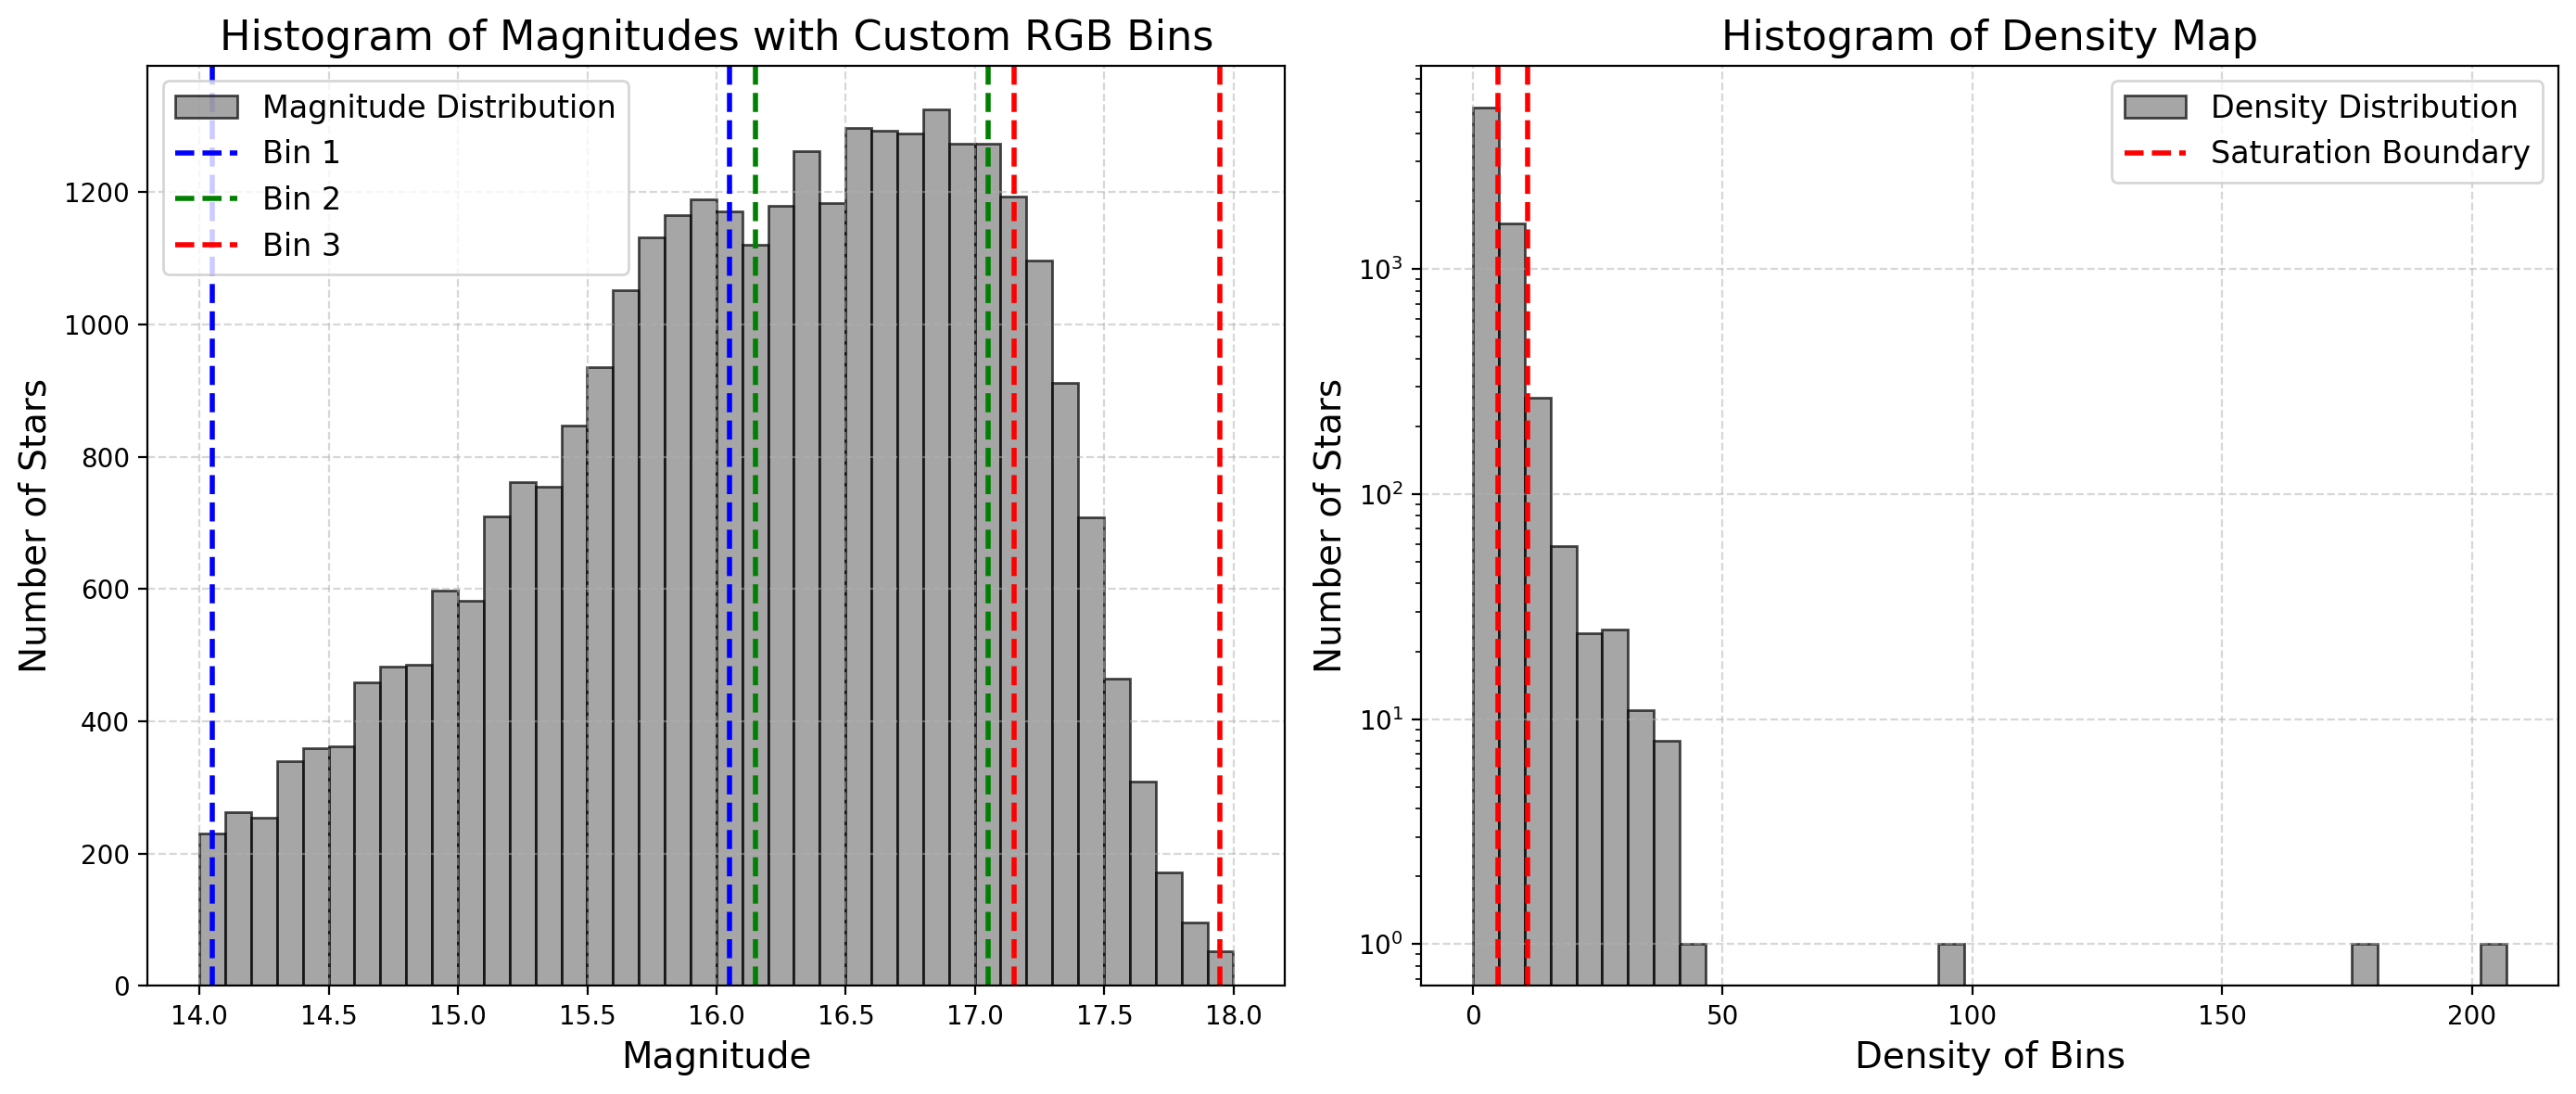

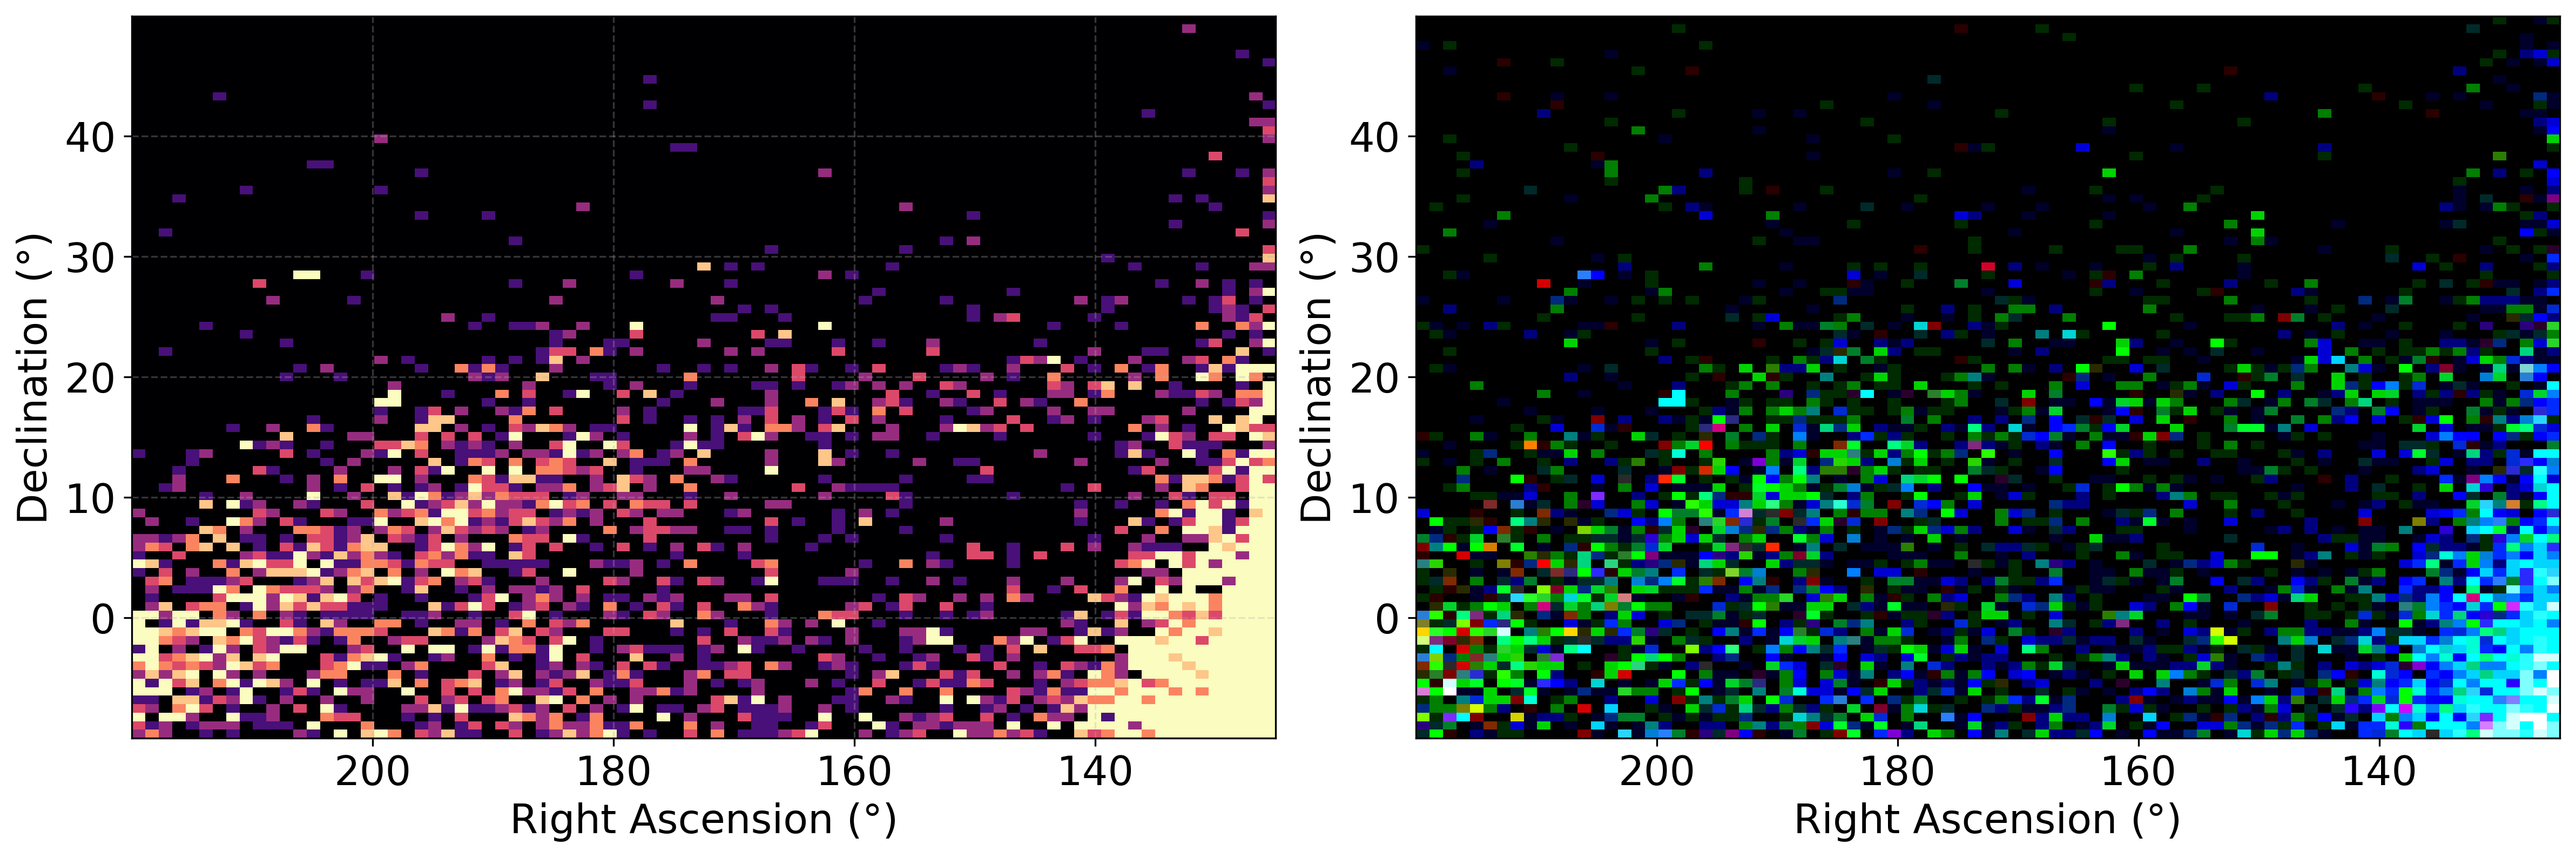

In [27]:
plot_sky_density_FS(fs_filtered, bins=85, contrast = (60,95), binning_method=(16.1,17.1), cmap_density="magma", density_bins = 40 , log_scale=True)

# All Sky View

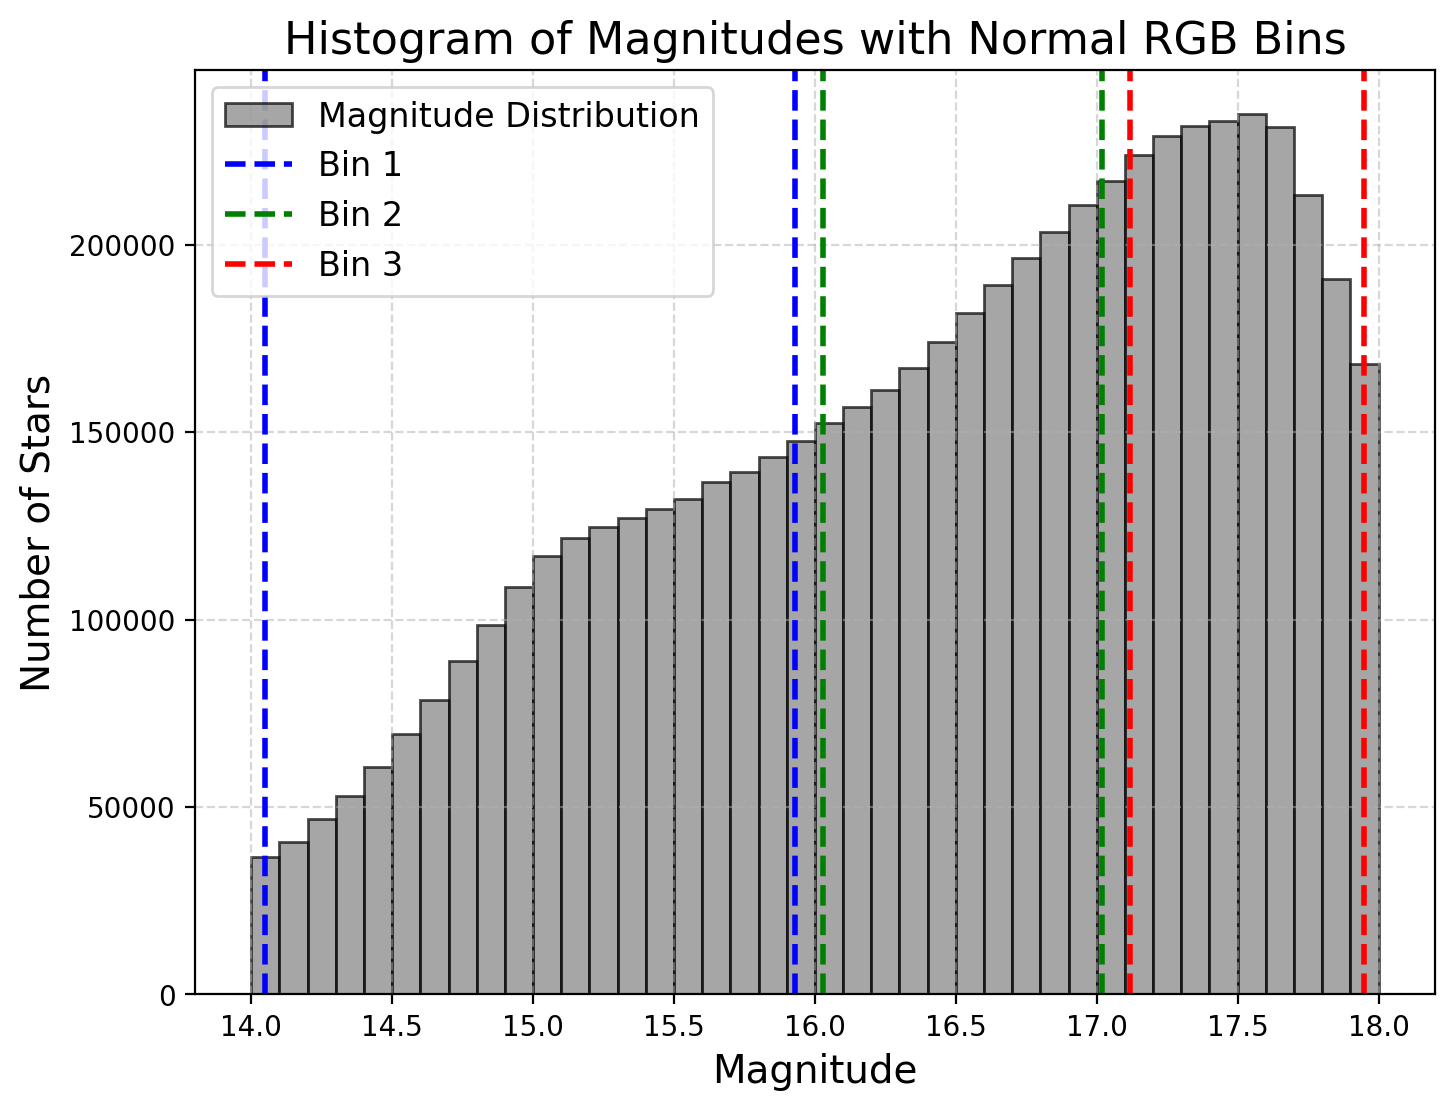

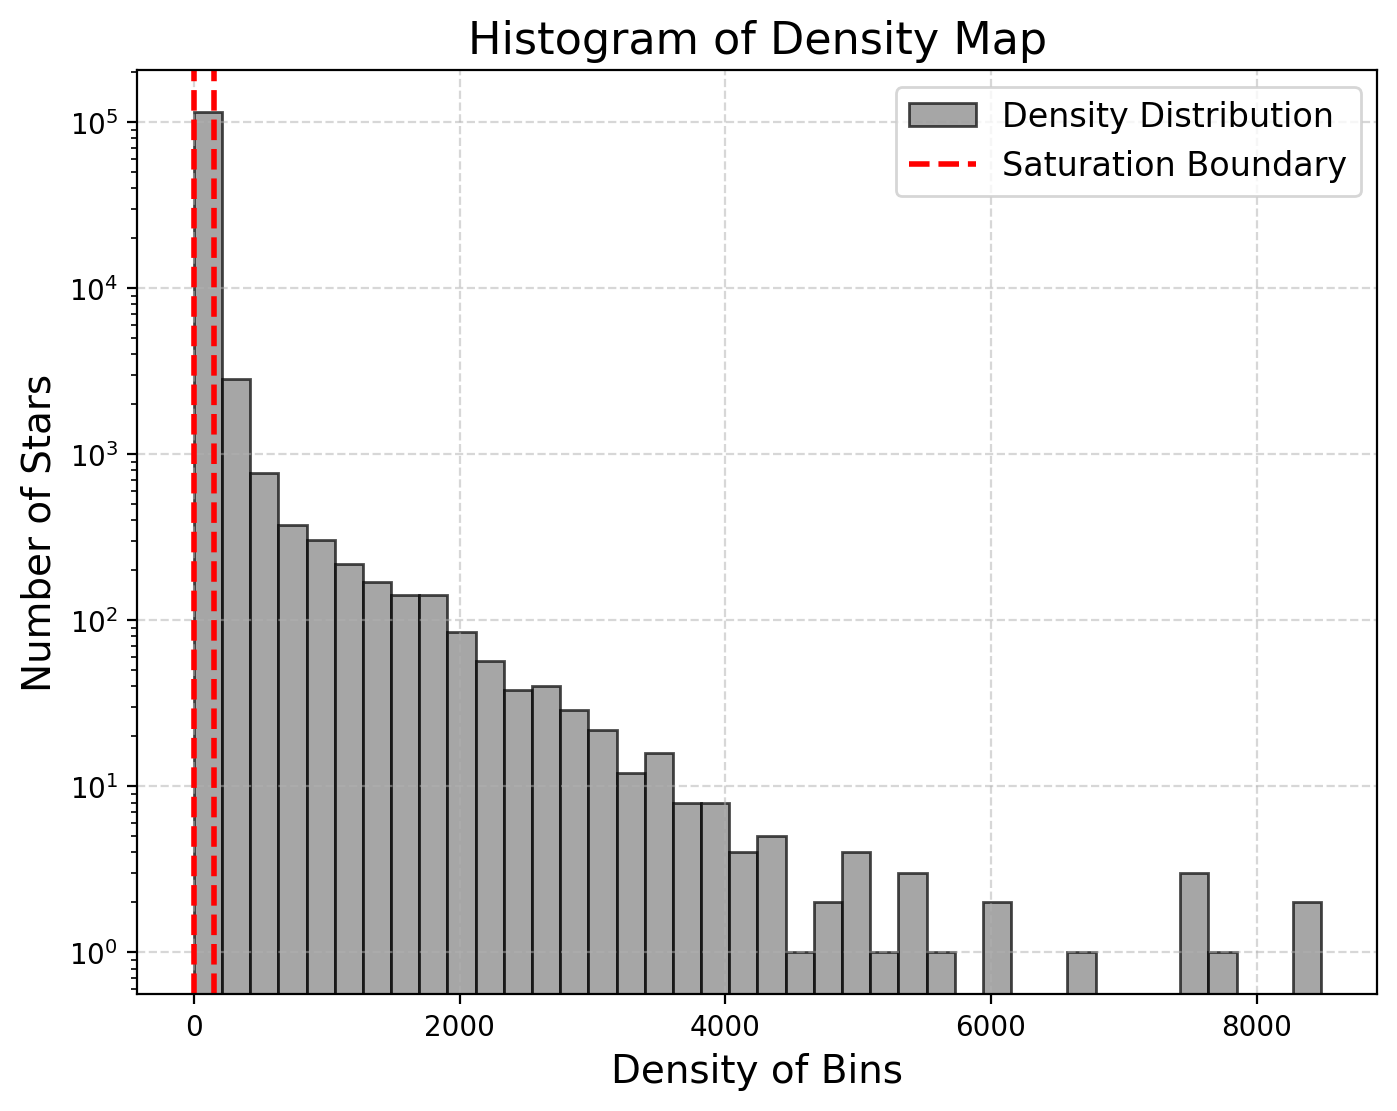

2025-03-23 18:17:08,780 - INFO - 0.0 180.0 -180.0 180.0
2025-03-23 18:17:08,780 - INFO - The interval between parallels is 30 deg -0.00'.
2025-03-23 18:17:08,787 - INFO - The interval between meridians is 30 deg -0.00'.


<Figure size 2000x1200 with 0 Axes>

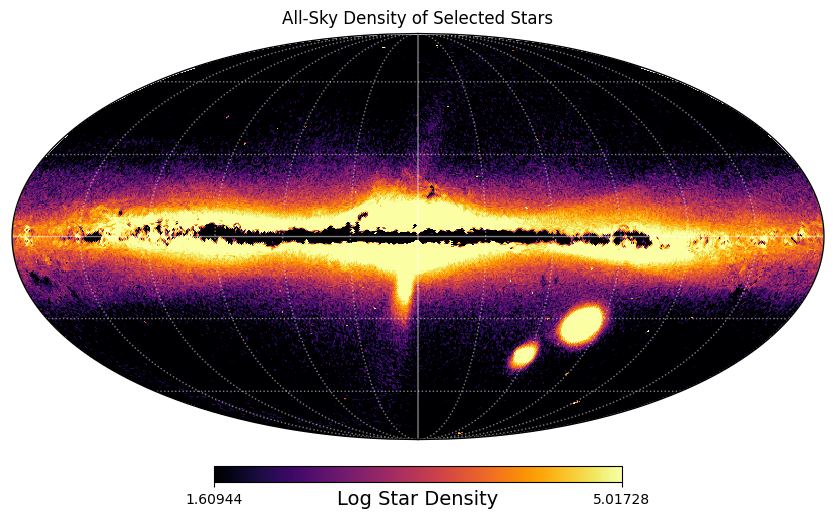

<Figure size 2000x1200 with 0 Axes>

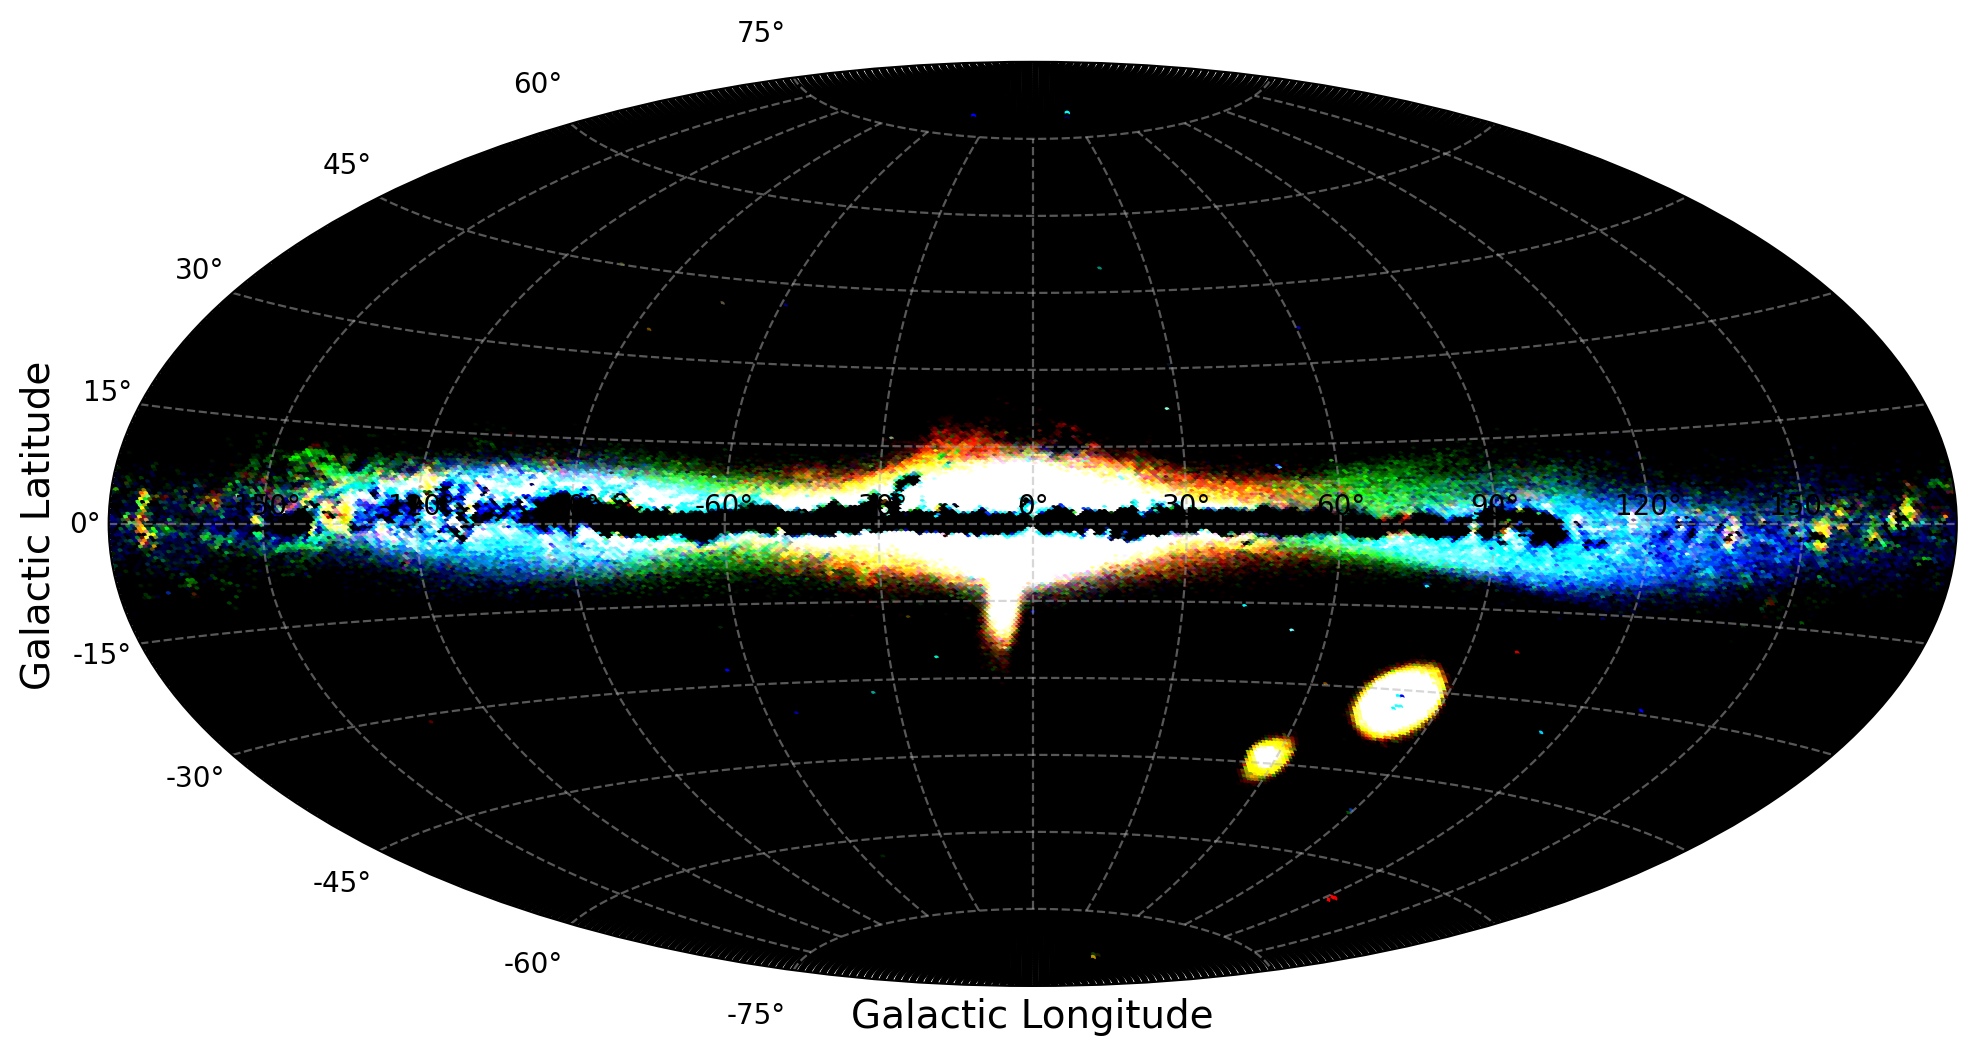

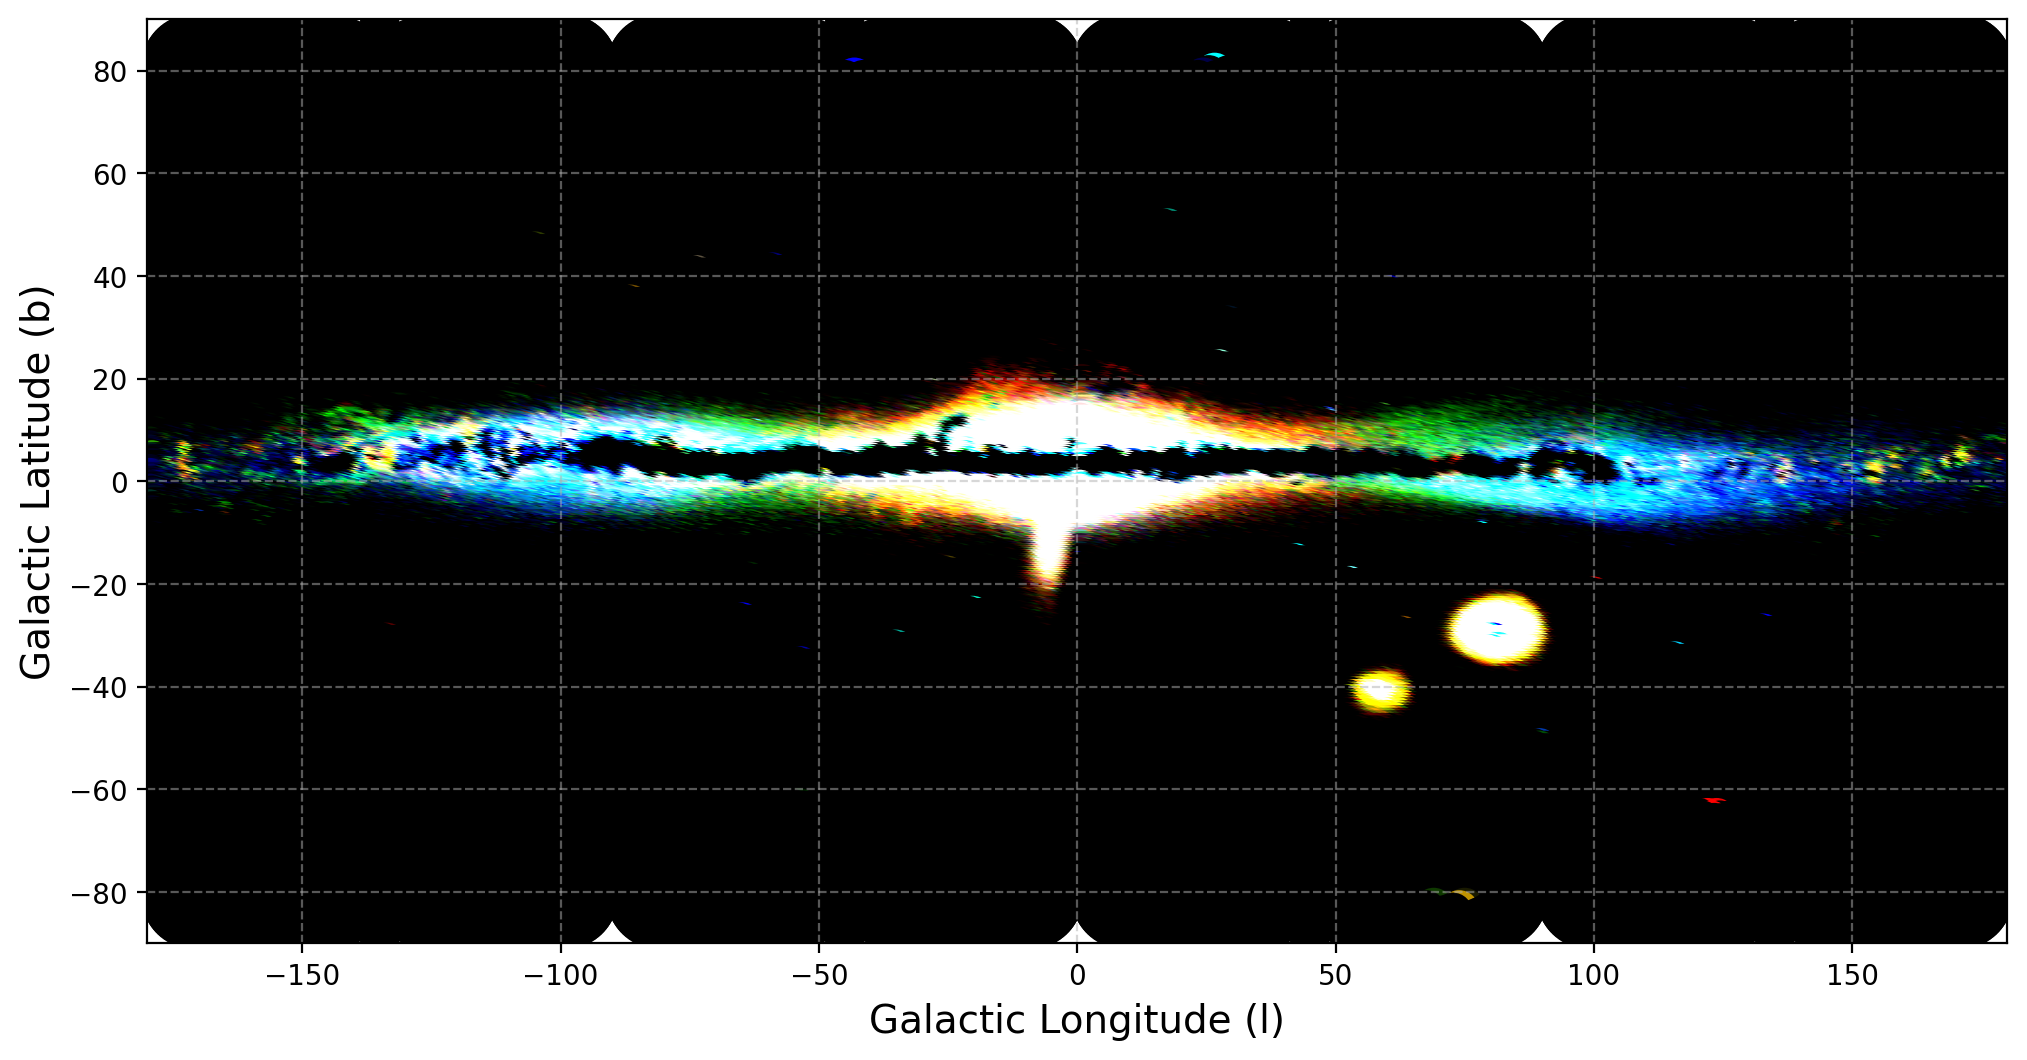

In [4]:
plot_sky_density_healpy(all_sky, nside=100, contrast=(80, 93), vmin =4 , vmax = 150, binning_method='normal', 
                             cmap_density="inferno", cmap_rgb="plasma", log_scale=True)

# Distances Probed by Data - Using Bailer Jones
- The filtered results of this are simply the same as the normal results presented in the next


In [6]:
# --- Load low proper motion dataset ---
with fits.open('data/Allsky_Gaia_42481846_extinction_corrected_filtered_allb.fits', memmap=True) as hdul:
    data_lowpm = hdul[1].data
    r_med_lowpm = data_lowpm['r_med_photogeo']
    b_lowpm = data_lowpm['b']
    w_lowpm = np.abs(b_lowpm) > 10
    r_med_lowpm_b = r_med_lowpm[w_lowpm]

# --- Load high proper motion dataset ---
with fits.open('data/Allsky_Gaia_45599440_extinction_corrected_filtered_allb.fits', memmap=True) as hdul:
    data_highpm = hdul[1].data
    r_med_highpm = data_highpm['r_med_photogeo']
    b_highpm = data_highpm['b']
    w_highpm = np.abs(b_highpm) > 10
    r_med_highpm_b = r_med_highpm[w_highpm]



In [18]:
print(f"Distance threshold: {15000:.2f} pc")
print(f"High PM (all): {np.sum(r_med_highpm > 15000)} stars beyond 15000pc, fraction {100*np.sum(r_med_highpm > 15000)/len(r_med_highpm):.4f}%")
print(f"High PM (|b| > 10): {np.sum(r_med_highpm_b > 15000)} stars beyond 15000pc, fraction {100*np.sum(r_med_highpm_b > 15000)/len(r_med_highpm_b):.4f}%")
print(f"High PM (|b| > 10) Max : {np.max(r_med_highpm_b)} pc")
print(f"Low PM (all): {np.sum(r_med_lowpm > 15000)} stars beyond 15000pc, fraction {np.sum(r_med_lowpm > 15000)/len(r_med_lowpm):.4f}%")
print(f"Low PM (|b| > 10): {np.sum(r_med_lowpm_b > 15000)} stars beyond 15000pc, fraction {100*np.sum(r_med_lowpm_b > 15000)/len(r_med_lowpm_b):.4f}%")
print(f"Low PM (|b| > 10) Max : {np.max(r_med_lowpm_b)} pc")

Distance threshold: 15000.00 pc
High PM (all): 15614 stars beyond 15000pc, fraction 0.0597%
High PM (|b| > 10): 11363 stars beyond 15000pc, fraction 0.1772%
High PM (|b| > 10) Max : 79661.0078125 pc
Low PM (all): 107253 stars beyond 15000pc, fraction 0.0101%
Low PM (|b| > 10): 99294 stars beyond 15000pc, fraction 3.1976%
Low PM (|b| > 10) Max : 79661.0078125 pc


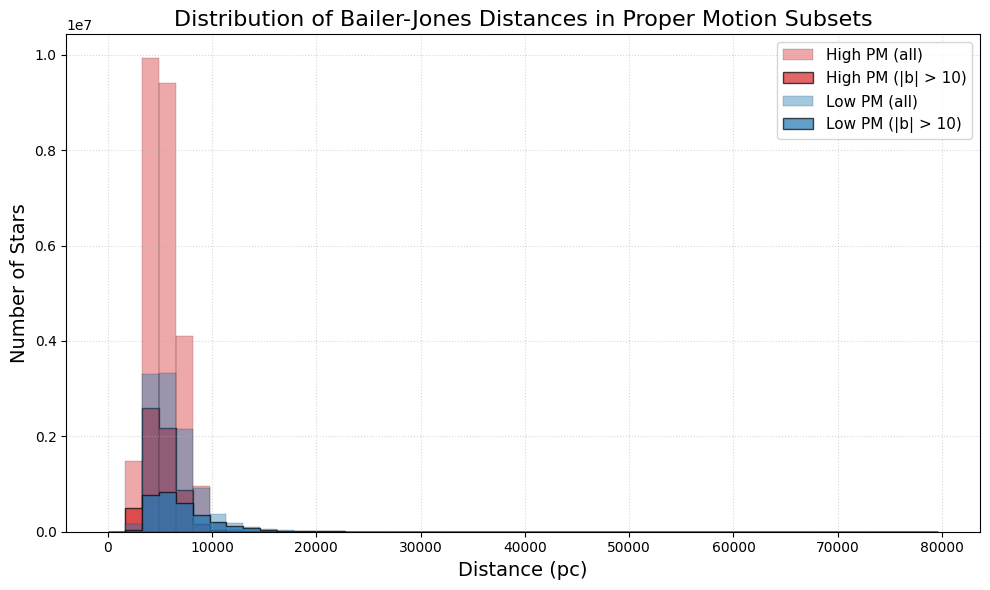

In [10]:
# --- Set consistent histogram bins ---
combined = np.concatenate([r_med_lowpm, r_med_lowpm_b, r_med_highpm, r_med_highpm_b])
bins = np.linspace(0, np.percentile(combined, 99.5), 50)

# --- Plot ---
plt.figure(figsize=(10, 6))

# High PM
plt.hist(r_med_highpm, bins=bins, alpha=0.4, color='tab:red', label='High PM (all)', edgecolor='black', linewidth=0.3)
plt.hist(r_med_highpm_b, bins=bins, alpha=0.7, color='tab:red', label='High PM (|b| > 10)', histtype='stepfilled', edgecolor='black')

# Low PM
plt.hist(r_med_lowpm, bins=bins, alpha=0.4, color='tab:blue', label='Low PM (all)', edgecolor='black', linewidth=0.3)
plt.hist(r_med_lowpm_b, bins=bins, alpha=0.7, color='tab:blue', label='Low PM (|b| > 10)', histtype='stepfilled', edgecolor='black')


# Labels and aesthetics
plt.xlabel("Distance (pc)", fontsize=14)
plt.ylabel("Number of Stars", fontsize=14)
plt.title("Distribution of Bailer-Jones Distances in Proper Motion Subsets", fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, linestyle='dotted', alpha=0.5)
plt.tight_layout()
plt.show()



In [22]:
# --- Set consistent histogram bins ---
combined = np.concatenate([r_med_lowpm_b, r_med_highpm_b])
bins = np.linspace(0, np.percentile(combined, 100), 50)

# --- Plot ---
plt.figure(figsize=(10, 6))

# High PM
plt.hist(r_med_highpm_b, bins=bins, alpha=0.7, color='tab:red', label='High PM', histtype='stepfilled', edgecolor='black')

# Low PM
plt.hist(r_med_lowpm_b, bins=bins, alpha=0.7, color='tab:blue', label='Low PM', histtype='stepfilled', edgecolor='black')


# Labels and aesthetics
plt.xlabel("Distance (pc)", fontsize=16)
plt.ylabel("Number of Stars", fontsize=16)
plt.title("Distribution of Bailer-Jones Distances in Proper Motion Subsets", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, linestyle='dotted', alpha=0.5)
plt.legend(loc='upper right', fontsize=14)
plt.tight_layout()
plt.show()